# Quantum Mechanics - Schrodinger Wave Equation

The Schrodinger wave equation describes the dynamics of quantum particles under the influence of external potentials.

$$ i \hbar \frac{\partial}{\partial t} \Psi(r,t) = \lbrace \frac{-\hbar^2}{2m} \nabla^2 + V(r,t) \rbrace \Psi(r,t)$$

Lets model the behaviour of a electron in a square potential well, a classic analytical solution.

In [1]:
import numpy as np
%matplotlib inline

#Some constants we are going to need.
h=6.626E-34 #planck constant in Joule.seconds
hbar=h/2*np.pi #Reduced planck constant
m=9.109E-31 #electron mass in kgs
i=np.complex(imag=1) # The imaginary number
vpot=19 # height of potential

In [2]:
# Some variable declarations
minx=0.000002
miny=0.000002
nx = 81
ny = 81
nt = 50
dx = minx / (nx - 1)
dy = miny / (ny - 1)
sigma = .25
dt = sigma * dx * dy

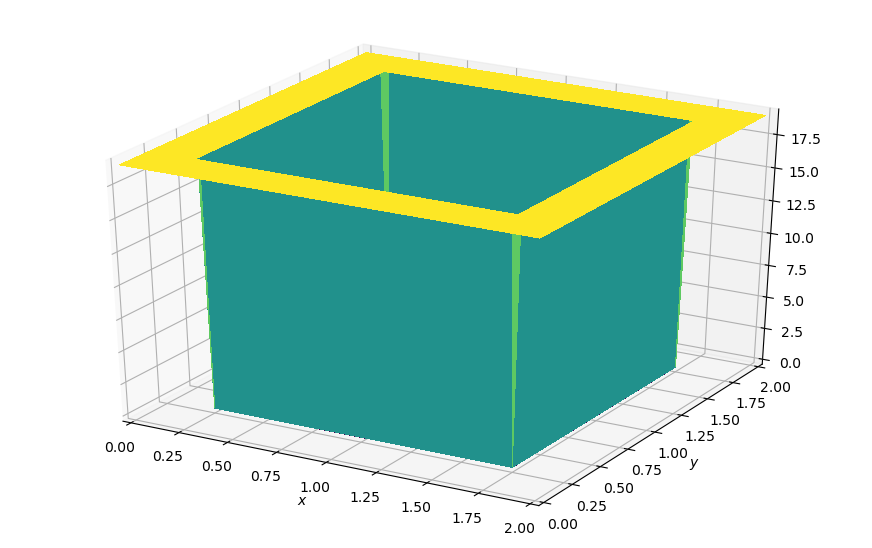

In [3]:
from examples.cfd import plot_field, init_hat

pot = np.empty((nx, ny))
init_hat(field=pot, dx=dx, dy=dy, value=0, bgvalue=vpot)
pot[10:-10, 10:-10] = 0

plot_field(pot,zmin=0,zmax=vpot)

In [4]:
from devito import Grid, TimeFunction, Eq, solve, Function
from sympy.abc import a,b,c

# Initialize `u` for space order 2
grid = Grid(shape=(nx, ny), extent=(minx, miny))
psi = TimeFunction(name='psi', grid=grid, space_order=2)

# Create an operator with second-order derivatives
a = Function(name='a',grid = grid) # Define as Function
a.data[:]= pot  # Pass the potential in order to be used in the operator.

# Create an equation with second-order derivatives
# Note c=i*hbar, b=-hbar^2/2*m, c=V(r,t)
eq = Eq(c*psi.dt, b * psi.laplace+a*psi)
stencil = solve(eq, psi.forward)
eq_stencil = Eq(psi.forward, stencil)

print(eq_stencil)


Eq(psi(t + dt, x, y), 2.0*(-1.0*b*dt*h_x**2*psi(t, x, y) + 0.5*b*dt*h_x**2*psi(t, x, y - h_y) + 0.5*b*dt*h_x**2*psi(t, x, y + h_y) - 1.0*b*dt*h_y**2*psi(t, x, y) + 0.5*b*dt*h_y**2*psi(t, x - h_x, y) + 0.5*b*dt*h_y**2*psi(t, x + h_x, y) + 0.5*c*h_x**2*h_y**2*psi(t, x, y) + 0.5*dt*h_x**2*h_y**2*a(x, y)*psi(t, x, y))/(c*h_x**2*h_y**2))


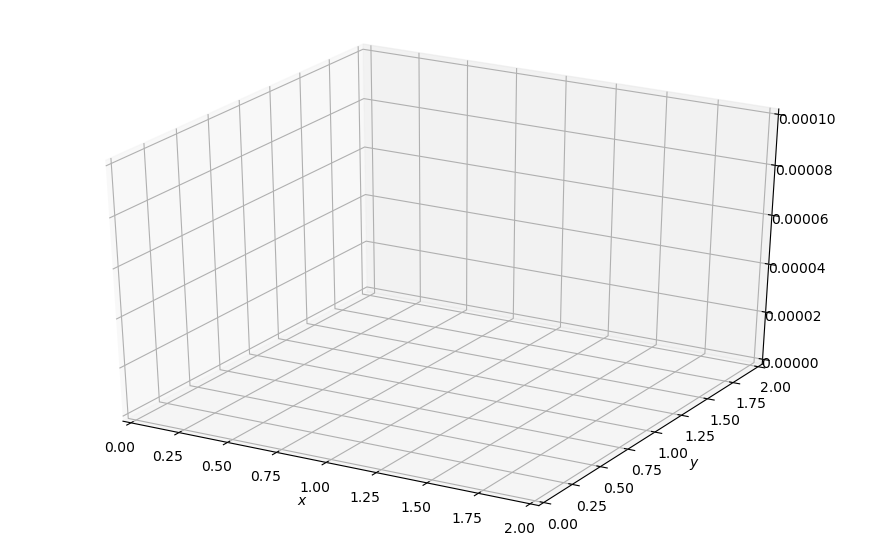

ArgumentError: error in argument 'c' with value '1.0408096461342984e-33j': argument 3: <class 'TypeError'>: wrong type

In [9]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator, Constant, Eq, solve, Function
zmax=0.01

# Reset our data field and ICs
init_hat(field=psi.data[0], dx=dx, dy=dy, value=0.0001)
plot_field(psi.data[0],zmin=0,zmax=0.0001)
# Set out potential field to be a sympy operator
a = Function(name='a',grid = grid) # Define as Function
# Field initialization
a.data[:]= pot  

b=Constant(name='b')
c=Constant(name='c')

# Create an equation with second-order derivatives
eq = Eq(c*psi.dt, b * psi.laplace+a*psi)
stencil = solve(eq, psi.forward)
eq_stencil = Eq(psi.forward, stencil)


# Create boundary condition expressions
x, y = grid.dimensions
t = grid.stepping_dim
bc = [Eq(psi[t+1, 0, y], 0.)]  # left
bc += [Eq(psi[t+1, nx-1, y], 0.)]  # right
bc += [Eq(psi[t+1, x, ny-1], 0.)]  # top
bc += [Eq(psi[t+1, x, 0], 0.)]  # bottom


op = Operator([eq_stencil] + bc)
op(time=nt, dt=dt, a = a, b=-(hbar*hbar)/(2*m), c=i*hbar)

print ("After", nt, "timesteps")
plot_field(psi.data[0], zmax=zmax)

op(time=nt, dt=dt, a = a)
print ("After another", nt, "timesteps")
plot_field(psi.data[0], zmax=zmax)